This tutorial reproduces the results of Tutorial 21 of spinw.org. It calculates the low temperature spin dynamics of YIG. 

Get Packages

In [13]:
using Sunny,GLMakie,CairoMakie

Define the lattice. Set up the lattice, the position of magnetic atoms, the symmetry inequivalent postions and the spin. The space group is I-a3d or 230. Note that there are two inequivalent Iron atom positions. The atoms have been indexed accordingly. Sunny uses the space group symmetry to produce all equivalent sites.

In [14]:
a = 12.3563
S=5/2
latvecs = lattice_vectors(a, a, a, 90, 90, 90)
positions=[[0, 0, 0],[0.375, 0.0, 0.25]]
types=["A","B"]
cryst = Crystal(latvecs,positions,230;types)
view_crystal(cryst)
print_symmetry_table(cryst,8)
sys=System(cryst, (1,1,1),[SpinInfo(1,S=1,g=2),SpinInfo(23,S=1,g=2.0)], :dipole, seed=0)

Atom 1
Type 'A', position [0, 0, 0], multiplicity 16
Allowed g-tensor: [  A B-C B+C
                   B+C   A B-C
                   B-C B+C   A]
Allowed anisotropy in Stevens operators:
    c₁*(𝒪[2,-2]+2𝒪[2,-1]+2𝒪[2,1]) +
    c₂*(-(7/2)𝒪[4,-4]+7𝒪[4,-3]+𝒪[4,-2]+3𝒪[4,-1]-4𝒪[4,1]) + c₃*(𝒪[4,-4]+6𝒪[4,-3]+2𝒪[4,-2]-2𝒪[4,-1]-8𝒪[4,3]) + c₄*(𝒪[4,0]+5𝒪[4,4]) +
    c₅*((33/5)𝒪[6,-6]+(66/5)𝒪[6,-5]-(12/5)𝒪[6,-4]+6𝒪[6,-3]+𝒪[6,-2]+4𝒪[6,-1]+(32/5)𝒪[6,1]) + c₆*((11/2)𝒪[6,-6]-33𝒪[6,-5]+6𝒪[6,-4]+𝒪[6,-3]-(9/2)𝒪[6,-2]+6𝒪[6,-1]-16𝒪[6,3]) + c₇*(𝒪[6,0]-21𝒪[6,4]) + c₈*(𝒪[6,-6]+10𝒪[6,-5]+4𝒪[6,-4]-10𝒪[6,-3]+5𝒪[6,-2]+4𝒪[6,-1]+32𝒪[6,5]) + c₉*(𝒪[6,2]-𝒪[6,6])

Atom 17
Type 'B', position [3/4, 1/8, 0], multiplicity 24
Allowed g-tensor: [A 0 -C
                   0 B  0
                   C 0  A]
Allowed anisotropy in Stevens operators:
    c₁*(𝒪[2,0]+3𝒪[2,2]) +
    c₂*(𝒪[4,0]-5𝒪[4,2]) + c₃*(-𝒪[4,1]+𝒪[4,3]) + c₄*(𝒪[4,0]+5𝒪[4,4]) +
    c₅*(𝒪[6,0]-21𝒪[6,4]) + c₆*(𝒪[6,1]+(5/2)𝒪[6,3]-(11/2)𝒪[6,5]) + c₇*(𝒪[6,0]+(105/16)𝒪

System [Dipole mode]
Lattice (1×1×1)×40
Energy per site 0


Set up the exchanges and the Hamiltonian. Note that the values for exchanges obtained from the paper have been converted to suitable units. The bonds also need to be correctly indexed due to the difference in indexing between Spinw and Sunny. Note that Jaa interaction is applied to both (1,5,[0,0,0]) and (2,5,[0,0,0]) bonds. These bonds have the same length but are symmetry inequivalent. The system has been reshaped into a new primitive cell to perform calculations. Randomize the spins and minimize the energy. Multiple minimizations may be required to obtain the ground state.

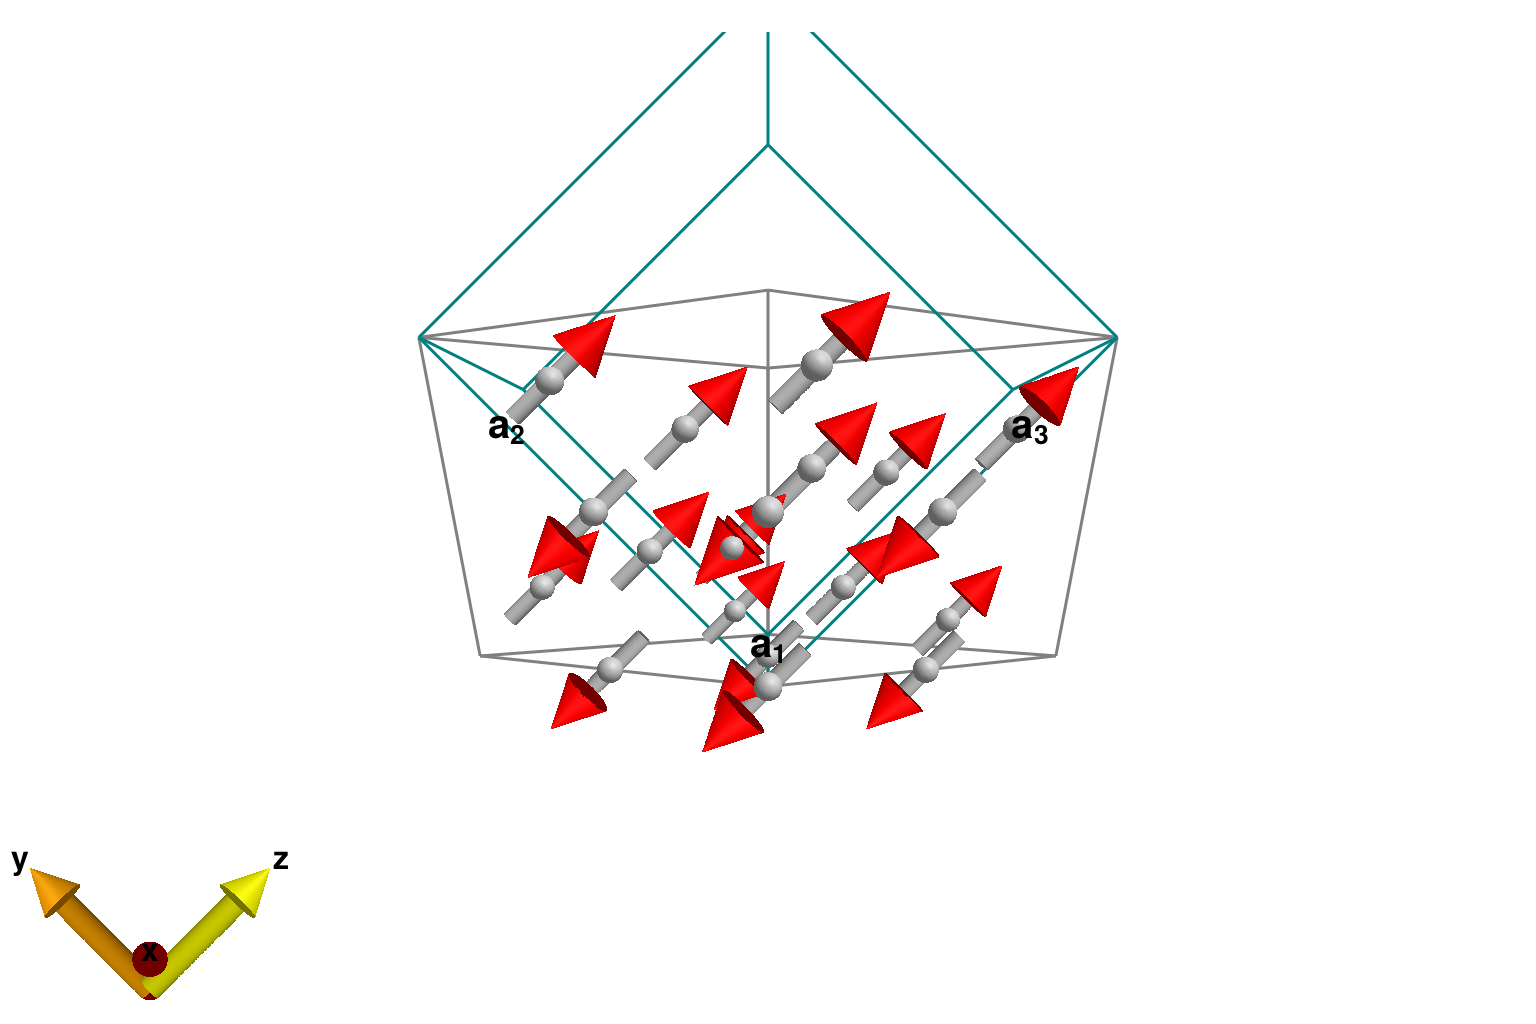

In [15]:
Jad = 59.9232/sqrt(S*(S+1))
Jdd = 20.22408/sqrt(S*(S+1))
Jaa = 5.74264/sqrt(S*(S+1))

set_exchange!(sys,Jad,Bond(2, 17, [0, 0, 0]))
set_exchange!(sys,Jdd,Bond(17, 21, [0, 0, 0]))
set_exchange!(sys,Jaa,Bond(2, 5, [0, 0, 0]))
set_exchange!(sys,Jaa,Bond(1, 5, [0, 0, 0]))
set_external_field!(sys,[0 0 0.01/(0.05788)])
sys_res=reshape_supercell(sys, [1/2 1/2 -1/2;-1/2 1/2 1/2;1/2 -1/2 1/2])

randomize_spins!(sys_res);
minimize_energy!(sys_res;maxiters=1000)
plot_spins(sys_res)

Set up the LSWT object and a path. Obtain the dispersion and intensity bands. Note that the calculations have been performed on the reshaped cell. Even though calculations were performed on the reshaped cell, Sunny allows us to plot the dispersion along a path with respect to the original cell as, which is very convenient.


In [16]:
q_points=[[1.5,2.5,3.0],[1,2,3],[1,2,4]]
density = 200
path, xticks = reciprocal_space_path(cryst, q_points, density);
swt = SpinWaveTheory(sys_res);
formula = intensity_formula(swt, :full; kernel=delta_function_kernel);
disp, intensity = intensities_bands(swt, path, formula);

Plot the dispersion. Here, the difference of the off diagonal components of the intensity matrix needs to be calculated. Also, only the imaginary values have been plotted, as per the results on spinw. Note that the figure on spinw has units Thz, so the values here have been scaled accordingly to match that result.

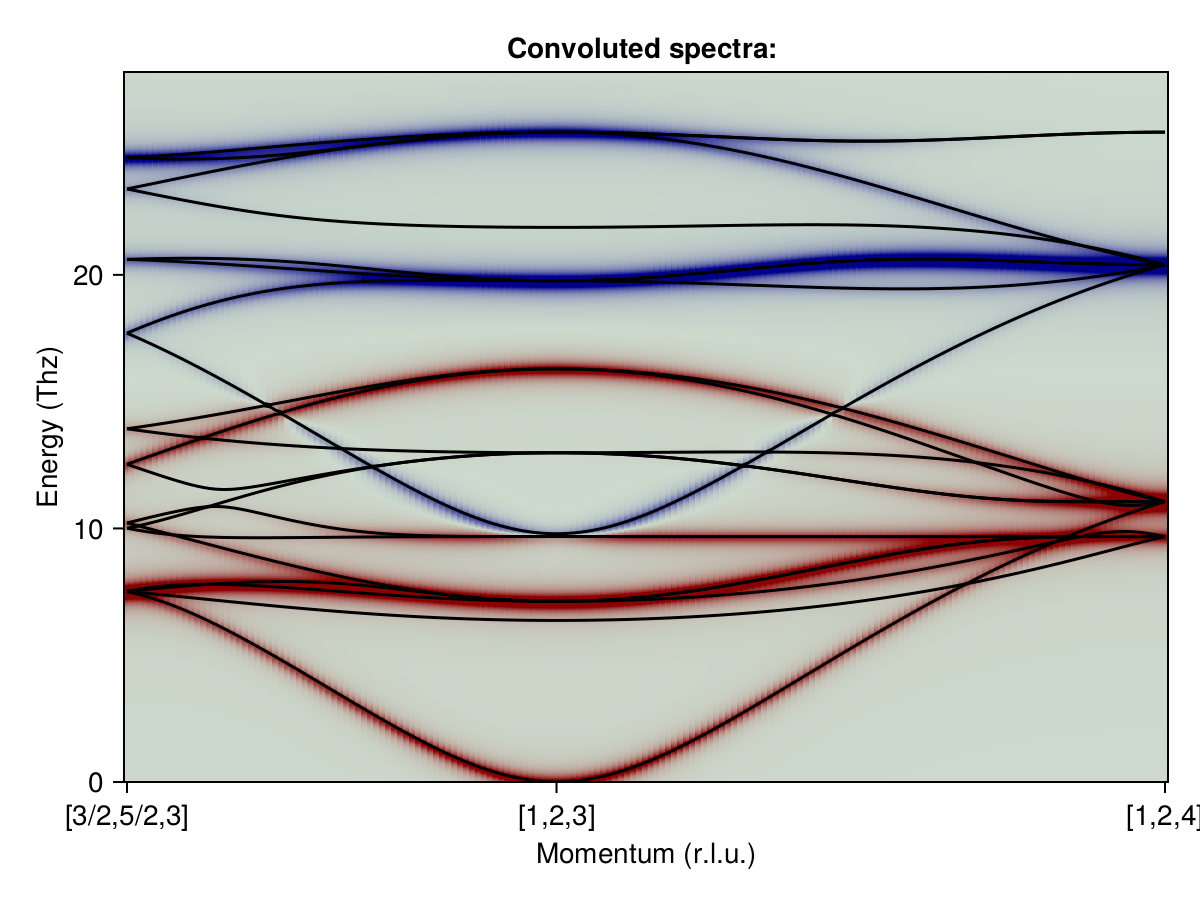

In [17]:
γ = 1;
broadened_formula = intensity_formula(swt, :full; kernel=lorentzian(γ));
energies = collect(0:0.02:140);
is = intensities_broadened(swt, path, energies, broadened_formula);

###calculating the difference Sxy-Sxy

is1=zeros(ComplexF64,length(path),length(energies));
for i  in 1:length(path)
    for j in 1:length(energies)
        is1[i,j] = is[i,j][1,2]-is[i,j][2,1]
    end
end 

CairoMakie.activate!()
fig = Figure()
ax = Axis(fig[1,1]; xlabel="Momentum (r.l.u.)", ylabel="Energy (Thz)", title="Convoluted spectra: ", xticks);
ylims!(ax, 0.0,28.0);
pl=heatmap!(ax, 1:size(is, 1), energies./4.136,imag(is1),colorrange=(-0.05,0.05));
pl.colormap = Reverse(:redsblues);
for i in axes(disp)[2]
    lines!(ax, 1:length(disp[:,i]), disp[:,i]/4.136; color="black")
end
fig
